In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats

from tqdm import tqdm
from multiprocessing import Pool

In [2]:
df = pd.read_pickle('../data/watch_list_clean.pkl.xz')

## Normalize User Ratings to their own rating behavior

In [3]:
df.head()

,title,url,username,status,times_watched,user_rating,num_eps,is_ongoing,duration,studio,start_year,end_year,season,avg_rating,num_votes,synopsis,tags,content_warnings
0,Day Break Illusion: il sole penetra le illusioni,https://www.anime-planet.com/anime/day-break-i...,Ruth,Watched,1,3.0,13,False,NaN,AIC,2013.0,2013.0,Summer,3.158,1980,Akari has always known two things: she’s a ski...,"[Drama, Fantasy, Horror, Magical Girl, Contemp...",None
1,Dog Days,https://www.anime-planet.com/anime/dog-days,Ruth,Watched,1,3.5,13,False,NaN,Seven Arcs,2011.0,2011.0,Spring,3.524,9447,"In the magical land of Flonyard, animal-eared ...","[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
2,Dog Days',https://www.anime-planet.com/anime/dog-days-2,Ruth,Watched,1,3.0,13,False,NaN,Seven Arcs,2012.0,2012.0,Summer,3.651,5345,Three months have passed since Shinku returned...,"[Action, Adventure, Ecchi, Fantasy, Animal Cha...",None
3,Fantasista Doll,https://www.anime-planet.com/anime/fantasista-...,Ruth,Watched,1,2.5,12,False,NaN,Hoods Entertainment,2013.0,2013.0,Summer,2.918,1206,Uzume Uno was on her way to class one day when...,"[Magical Girl, Sci Fi, Seinen, Slice of Life, ...",None
4,Fate/Kaleid Liner Prisma Illya,https://www.anime-planet.com/anime/fate-kaleid...,Ruth,Watched,1,3.5,10,False,NaN,SILVER LINK.,2013.0,2013.0,Summer,3.513,5655,Illya loves magical girls; but more than anyth...,"[Action, Fantasy, Magical Girl, Shounen, Conte...",None


In [4]:
def user_rating_normalizer(data):
    return ((data - data.median()) / (data.quantile(0.75) - data.quantile(0.25))).replace(np.NaN, 0)

In [5]:
df['adj_user_rating'] = df.groupby('username')['user_rating'].apply(user_rating_normalizer)

In [6]:
df['adj_user_rating'].agg(['min', 'max'])

min   -inf
max    inf
Name: adj_user_rating, dtype: float32

In [7]:
df['adj_user_rating']

0         -0.363636
1          0.000000
2         -0.363636
3         -0.727273
4          0.000000
             ...   
9205629    0.000000
9205630    0.000000
9205631    0.000000
9205632    0.000000
9205633    0.000000
Name: adj_user_rating, Length: 9205634, dtype: float32

ValueError: supplied range of [-inf, inf] is not finite

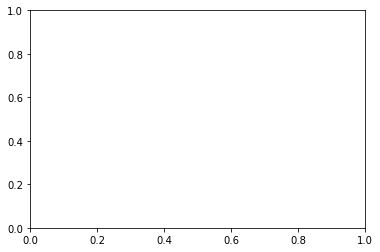

In [8]:
plt.hist(df['adj_user_rating'], bins=100)
plt.xlim(-1.1, 1.1)

/home/alancmathew/miniconda3/envs/anime-recommendation-engine/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<AxesSubplot:xlabel='adj_user_rating'>

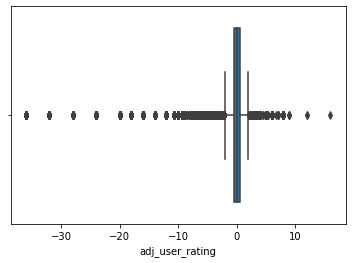

In [9]:
sns.boxplot(data=df, x='adj_user_rating')

In [10]:
df['adj_user_rating'].value_counts(dropna=False).sort_index()

-inf     54568
-36.0       29
-32.0       24
-28.0       18
-24.0       34
         ...  
 8.0        93
 9.0         3
 12.0        2
 16.0        1
 inf      7880
Name: adj_user_rating, Length: 551, dtype: int64

## Normalize Average Ratings

In [ ]:
df['avg_rating'].apply(lambda x: x - )